<a href="https://colab.research.google.com/github/WontonSoup914/MLStuff/blob/main/Classification_TXT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports + Version Control

In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing

In [2]:
print(tf.__version__)

2.6.0


# Sentiment Analysis

In [3]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset = tf.keras.utils.get_file("aclImdb_v1", url, untar=True, cache_dir='.', cache_subdir='')
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84140032/84125825 [==============================] - 25s 0us/step


In [4]:
os.listdir(dataset_dir)
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['unsupBow.feat',
 'urls_unsup.txt',
 'neg',
 'urls_neg.txt',
 'urls_pos.txt',
 'unsup',
 'labeledBow.feat',
 'pos']

In [8]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


**Load Dataset**

In [10]:
"""main_directory/
...class_a/
......a_text_1.txt
......a_text_2.txt
...class_b/
......b_text_1.txt
......b_text_2.txt"""

remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [11]:
batch_size = 32
seed = 69420

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [12]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(4):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])
    print()

Review b"IVAN (Marco Ricca) and GILBERTO (Alexandre Borges) are partners in a company together with ESTEV\xc3\x83O (George Freire), but the first ones contract a professional killer, ANISIO, to murder ESTEV\xc3\x83O (the plot, at least at the beginning, doesn't explain very well why). The guy does it and after receiving his money he starts blackmailing the two partners, appearing in their company and saying he wants a job there (as supervisor or something\xc2\x85). At the same time he meets MARINA (Mariana Ximenes), daughter of ESTEV\xc3\x83O, and starts dating with her! <br /><br />In a story like this, where crime, corruption, betrayal and blackmail go hand in hand, no one is innocent or can be victimized, exception made to MARINA, which is the only person who doesn't know what's going on and didn't betray anyone\xc2\x85 <br /><br />This film portrays with sarcasm the sad and cruel reality which exists in big metropolis like S\xc3\xa3o Paulo, where crime is every day's presence. We c

In [13]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [14]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.25, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 6250 files for validation.


In [15]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


**Prepare Dataset for Training**

In [16]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [17]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [18]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [19]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [20]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b"The Ladies Man is a funny movie. There's not much thought behind it, but what do you expect from an SNL movie? It's actually better than most SNL movies (i.e. Superstar or A Night At The Roxbury) Tim Meadows and Will Ferrell were both very funny. Chris Parnell was also funny in his short scene (one of the funnier ones in the movie). Other than that, the rest of the cast is average and is just there to support Meadows. I've definitely seen funnier movies, but I've seen dumber ones too. Again, it's not exactly a deep movie, but it's good for a few laughs. It was funnier as a skit though. But still, if you're looking for a pretty funny movie, I'd recommend this one. Just don't think about it too much, or you'll hate it.<br /><br />Rating: 6/10", shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[   2, 1728,  135,    7,    4,  160,   17,  221,   21,   72,  197,
         491,    9,   18,   48,   82,   22,  525,   3

In [21]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  historical
 313 --->  excellent
Vocabulary size: 10000


In [22]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

**Configure for Performance**

In [23]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Create Model**

In [24]:
embedding_dim = 16
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

**Train Model**

In [26]:
epochs = 69
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/69
625/625 [==============================] - 12s 18ms/step - loss: 0.6642 - binary_accuracy: 0.6921 - val_loss: 0.6124 - val_binary_accuracy: 0.7758
Epoch 2/69
625/625 [==============================] - 4s 7ms/step - loss: 0.5479 - binary_accuracy: 0.8028 - val_loss: 0.4926 - val_binary_accuracy: 0.8296
Epoch 3/69
625/625 [==============================] - 4s 7ms/step - loss: 0.4430 - binary_accuracy: 0.8453 - val_loss: 0.4137 - val_binary_accuracy: 0.8549
Epoch 4/69
625/625 [==============================] - 4s 7ms/step - loss: 0.3770 - binary_accuracy: 0.8674 - val_loss: 0.3678 - val_binary_accuracy: 0.8635
Epoch 5/69
625/625 [==============================] - 4s 7ms/step - loss: 0.3334 - binary_accuracy: 0.8806 - val_loss: 0.3391 - val_binary_accuracy: 0.8704
Epoch 6/69
625/625 [==============================] - 4s 7ms/step - loss: 0.3024 - binary_accuracy: 0.8896 - val_loss: 0.3199 - val_binary_accuracy: 0.8725
Epoch 7/69
625/625 [==============================] - 5s 7ms/s

**Evaluate Model**

In [27]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 9s 11ms/step - loss: 0.9976 - binary_accuracy: 0.8325
Loss:  0.9975864291191101
Accuracy:  0.8324800133705139


In [28]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

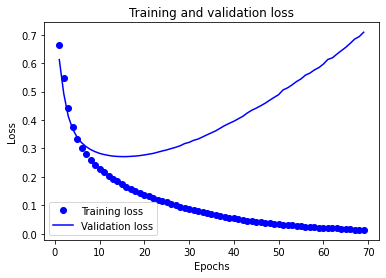

In [29]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

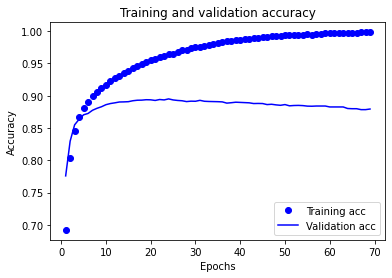

In [30]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

**Export Model**

In [31]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 9s 11ms/step - loss: 0.9976 - accuracy: 0.8325
0.8324800133705139


In [32]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

array([[0.77301455],
       [0.309153  ],
       [0.11862704]], dtype=float32)

In [33]:
# MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.